# Generating an Observed SED form a Parametric Galaxy

Building on the *Generate a Rest Frame SED* tutorial here we instead generate an observed frame SED and broadband photometry: 


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric.sfzh import SFH, ZH, generate_sfzh
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.plt import single, single_histxy, mlabel
from unyt import yr, Myr
from synthesizer.igm import Madau96, Inoue14

In [11]:
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir)

Again, let's define the star formation and metal enrichment history and make a `Galaxy` object.

In [12]:
# define the parameters of the star formation and metal enrichment histories
sfh_p = {'duration': 10 * Myr}
Z_p = {'log10Z': -2.0}  # can also use linear metallicity e.g. {'Z': 0.01}
stellar_mass = 1E8

# define the functional form of the star formation and metal enrichment histories
sfh = SFH.Constant(sfh_p)  # constant star formation
Zh = ZH.deltaConstant(Z_p)  # constant metallicity

# get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).
sfzh = generate_sfzh(grid.log10age, grid.metallicity, sfh, Zh, stellar_mass=stellar_mass)

# create a galaxy object
galaxy = Galaxy(sfzh)

Now let's generate a spectral energy distribution with the Pacman model. Note, applying this method both saves a copy of the spectra but also returns it, a la:

In [13]:
sed = galaxy.get_spectra_pacman(grid, fesc=0.5, fesc_LyA=0.5, tauV=0.1)

Next we want to generate the observed frame spectra. This requires that we define a cosmology, specify a redshift, and optionally provide an IGM function:

In [14]:
from astropy.cosmology import Planck18 as cosmo
z = 10.  # redshift
sed.get_fnu(cosmo, z, igm=Madau96())  # generate observed frame spectra

Let's now define a collection of filters to apply to this SED. See the Filters tutorial for more detail about `Filter` and `FilterCollection` objects. Let's use the JWST/NIRCam wide filters:

In [15]:
filter_codes = [f'JWST/NIRCam.{f}' for f in ['F070W','F090W', 'F115W', 'F150W',
                                             'F200W', 'F277W', 'F356W', 'F444W']]  # define a list of filter codes
fc = FilterCollection(filter_codes, new_lam=grid.lam)

Next let's calculate the broadband fluxes using these filters:

In [16]:
# measure broadband fluxes
fluxes = sed.get_broadband_fluxes(fc)

# print broadband fluxes
for filter, flux in fluxes.items():
    print(f'{filter}: {flux:.2f}')

JWST/NIRCam.F070W: -0.00 nJy
JWST/NIRCam.F090W: 0.00 nJy
JWST/NIRCam.F115W: 0.00 nJy
JWST/NIRCam.F150W: 76.12 nJy
JWST/NIRCam.F200W: 67.00 nJy
JWST/NIRCam.F277W: 58.55 nJy
JWST/NIRCam.F356W: 49.41 nJy
JWST/NIRCam.F444W: 48.43 nJy


We can also make a plot of the spectra, including filter transmission function curves.

total


(<Figure size 350x500 with 2 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda_{obs}/\\AA)$', ylabel='$\\rm log_{10}(f_{\\nu}/nJy)$'>)

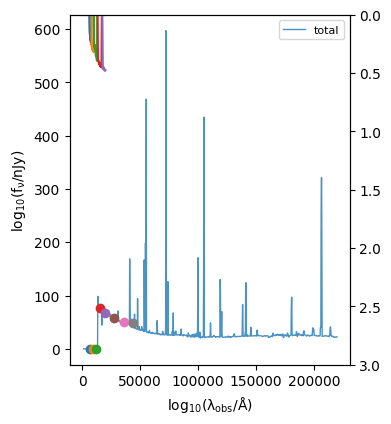

In [17]:
galaxy.plot_observed_spectra(cosmo, z, fc=fc, spectra_to_plot=['total'])